In [1]:
from dask.dataframe.utils import assert_dask_dtypes
from jmetal.algorithm.multiobjective import RandomSearch, NSGAII, SPEA2, MOEAD
from jmetal.operator.crossover import SBXCrossover, DifferentialEvolutionCrossover
from jmetal.operator.mutation import PolynomialMutation
from jmetal.problem.multiobjective.unconstrained import Schaffer, Kursawe
from jmetal.problem.multiobjective.constrained import Srinivas, Tanaka, Osyczka2, Binh2
from jmetal.util.aggregation_function import PenaltyBoundaryIntersection
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.solution import get_non_dominated_solutions, print_function_values_to_file
from jmetal.core.quality_indicator import HyperVolume,NormalizedHyperVolume, InvertedGenerationalDistance
import time
import numpy as np
import matplotlib.pyplot as plt


def execute_analysis(problem, algorithm_max_evaluations):
    problem_name = problem.name() 
    ref_front = np.loadtxt(f"resources/reference_fronts/{problem_name}.pf")
    pop_size = 100
    off_size = 100
    cro = 0.7
    mut = 0.5
    
    rnd = RandomSearch(
        problem=problem,
        termination_criterion=StoppingByEvaluations(max_evaluations=algorithm_max_evaluations)
    )
    
    nsgaII = NSGAII(
            problem=problem,
            population_size=pop_size,
            offspring_population_size=off_size,
            mutation=PolynomialMutation(mut, distribution_index=20),
            crossover=SBXCrossover(probability=cro, distribution_index=20),
            termination_criterion=StoppingByEvaluations(max_evaluations=algorithm_max_evaluations))
    
    spea2 = SPEA2(
            problem=problem,
            population_size=pop_size,
            offspring_population_size=off_size,
            mutation=PolynomialMutation(mut, distribution_index=20),
            crossover=SBXCrossover(probability=cro, distribution_index=20),
            termination_criterion=StoppingByEvaluations(max_evaluations=algorithm_max_evaluations))
    
    moead = MOEAD(
            problem=problem,
            population_size=pop_size,
            crossover=DifferentialEvolutionCrossover(CR=1.0, F=0.5),
            mutation=PolynomialMutation(mut, distribution_index=20),
            aggregation_function=PenaltyBoundaryIntersection(dimension=problem.number_of_objectives()),
            neighbor_size=20,
            neighbourhood_selection_probability=0.9,
            max_number_of_replaced_solutions=2,
            weight_files_path="resources/MOEAD_weights",
            termination_criterion=StoppingByEvaluations(max_evaluations=algorithm_max_evaluations))
    
    algorithms = [rnd, nsgaII, spea2, moead]
    
    for algorithm in algorithms:
        algorithm.run()
        front = get_non_dominated_solutions(algorithm.result())
        filepath = f'results/sample_calculations/FUN.{algorithm.get_name()}.{problem_name}'
        print_function_values_to_file(front, filepath)
        
        aprx_front = np.loadtxt(filepath)
        
        hv_ref_point = np.max(ref_front, axis=0) + 0.1
        nhv = NormalizedHyperVolume(hv_ref_point, ref_front)
        hv = HyperVolume(hv_ref_point)
        igd = InvertedGenerationalDistance(ref_front)
        print(f'{algorithm.get_name()}, {problem_name}, HV = {hv.compute(aprx_front.reshape(-1, problem.number_of_objectives()))}, nHV = {nhv.compute(aprx_front.reshape(-1, problem.number_of_objectives()))}, IGD = {igd.compute(aprx_front.reshape(-1, problem.number_of_objectives()))}')
            

In [2]:
def generate_plots(problem_name):
    ref_front = np.loadtxt(f"resources/reference_fronts/{problem_name}.pf")
    ref_x = ref_front[:, 0]
    ref_y = ref_front[:, 1]
    
    hv_ref_point = np.max(ref_front, axis=0) + 0.1
    hv = HyperVolume(hv_ref_point)
    nhv = NormalizedHyperVolume(hv_ref_point, ref_front)
    igd = InvertedGenerationalDistance(ref_front)
    
    fun1 = np.loadtxt(f"results/sample_calculations/FUN.Random Search.{problem_name}").reshape(-1, 2)
    fun1_x = fun1[:, 0]
    fun1_y = fun1[:, 1]
    fun1_hv = hv.compute(fun1)
    fun1_nhv = nhv.compute(fun1)
    fun1_igd = igd.compute(fun1)
    
    fun2 = np.loadtxt(f"results/sample_calculations/FUN.NSGAII.{problem_name}").reshape(-1, 2)
    fun2_x = fun2[:, 0]
    fun2_y = fun2[:, 1]
    fun2_hv = hv.compute(fun2)
    fun2_nhv = nhv.compute(fun2)
    fun2_igd = igd.compute(fun2)
    
    fun3 = np.loadtxt(f"results/sample_calculations/FUN.SPEA2.{problem_name}").reshape(-1, 2)
    fun3_x = fun3[:, 0]
    fun3_y = fun3[:, 1]
    fun3_hv = hv.compute(fun3)
    fun3_nhv = nhv.compute(fun3)
    fun3_igd = igd.compute(fun3)
    
    fun4 = np.loadtxt(f"results/sample_calculations/FUN.MOEAD.{problem_name}").reshape(-1, 2)
    fun4_x = fun4[:, 0]
    fun4_y = fun4[:, 1]
    fun4_hv = hv.compute(fun4)
    fun4_nhv = nhv.compute(fun4)
    fun4_igd = igd.compute(fun4)
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), constrained_layout=True)
    bbox_props = dict(boxstyle='square', facecolor='w', alpha=1)
    ref_s = 2
    fun_s = 20
    ndigits = 4
    legend_h = -30
    legend_v = -30
    alpha = 0.7
    fontsize = 12

    plt.subplot(221) # (rows-columns-index)
    plt.xlabel("$f_1{(x)}$")
    plt.ylabel("$f_2{(x)}$")
    plt.grid(True)
    plt.scatter(ref_x, ref_y, marker="o", facecolors='blue', s=ref_s)
    plt.scatter(fun1_x, fun1_y, marker="o", facecolors='red', s=fun_s, alpha=alpha)
    plt.title(f'a) Random Search (nHV = {round(fun1_nhv, ndigits)}, IGD = {round(fun1_igd, ndigits)})', fontsize=fontsize)
    
    plt.subplot(222)
    plt.xlabel("$f_1{(x)}$")
    plt.ylabel("$f_2{(x)}$")
    plt.grid(True)
    plt.scatter(ref_x, ref_y, marker="o", facecolors='blue', s=ref_s)
    plt.scatter(fun2_x, fun2_y, marker="o", facecolors='red', s=fun_s, alpha=alpha)
    plt.title(f'b) NSGAII (nHV = {round(fun2_nhv, ndigits)}, IGD = {round(fun2_igd, ndigits)})', fontsize=fontsize)
    
    plt.subplot(223)
    plt.xlabel("$f_1{(x)}$")
    plt.ylabel("$f_2{(x)}$")
    plt.grid(True)
    plt.scatter(ref_x, ref_y, marker="o", facecolors='blue', s=ref_s)
    plt.scatter(fun3_x, fun3_y, marker="o", facecolors='red', s=fun_s, alpha=alpha)
    plt.title(f'c) SPEA2 (nHV = {round(fun3_nhv, ndigits)}, IGD = {round(fun3_igd, ndigits)})', fontsize=fontsize)
    
    plt.subplot(224)
    plt.xlabel("$f_1{(x)}$")
    plt.ylabel("$f_2{(x)}$")
    plt.grid(True)
    plt.scatter(ref_x, ref_y, marker="o", facecolors='blue', s=ref_s)
    plt.scatter(fun4_x, fun4_y, marker="o", facecolors='red', s=fun_s, alpha=alpha)
    plt.title(f'd) MOEAD (nHV = {round(fun4_nhv, ndigits)}, IGD = {round(fun4_igd, ndigits)})', fontsize=fontsize)
    
    fig.savefig(f'img/{problem_name}_results.png')
    plt.show()

In [108]:
algorithm_max_evaluations = 10000

In [3]:
problem = Kursawe()

In [110]:
execute_analysis(problem, algorithm_max_evaluations)

[2025-10-10 19:48:40,211] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-10 19:48:40,216] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-10 19:48:40,218] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-10 19:48:40,226] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2025-10-10 19:48:40,538] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-10 19:48:40,540] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.Kursawe
[2025-10-10 19:48:40,553] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-10 19:48:40,559] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-10 19:48:40,561] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-10 19:48:40,562] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, Kursawe, HV = 19.791121238522905, nHV = 0.28836405929850284, IGD = 0.8200266142901582


[2025-10-10 19:48:47,327] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-10 19:48:47,334] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.Kursawe
[2025-10-10 19:48:47,354] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-10 19:48:47,358] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-10 19:48:47,362] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-10 19:48:47,364] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, Kursawe, HV = 27.439448947461837, nHV = 0.013350591473862083, IGD = 0.04231647018602784


[2025-10-10 19:51:06,166] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-10 19:51:06,170] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.Kursawe
[2025-10-10 19:51:06,185] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-10 19:51:06,187] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-10 19:51:06,190] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-10 19:51:06,191] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, Kursawe, HV = 27.50843069253823, nHV = 0.010870191881689584, IGD = 0.03379695013831537


[2025-10-10 19:51:09,589] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-10 19:51:09,593] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.Kursawe


MOEAD, Kursawe, HV = 26.89114806093871, nHV = 0.03306602914238865, IGD = 0.06843263899413986


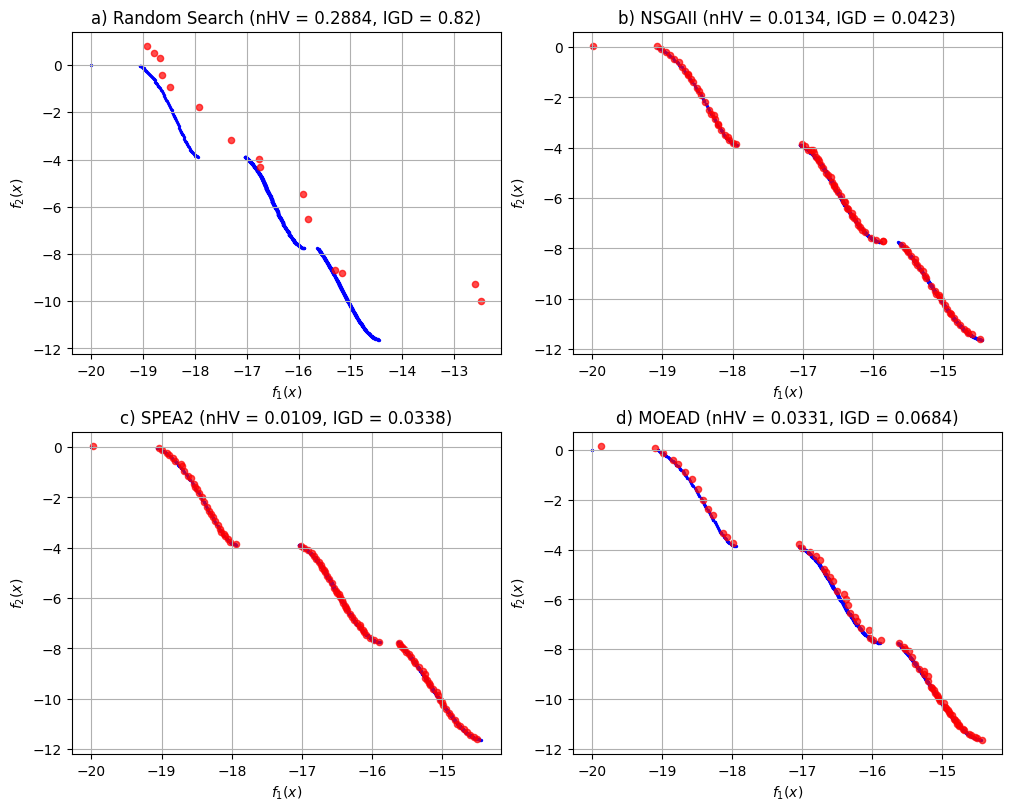

In [4]:
generate_plots(problem.name())

In [5]:
problem = Binh2()

In [113]:
execute_analysis(problem, algorithm_max_evaluations)

[2025-10-10 19:51:11,508] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-10 19:51:11,510] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-10 19:51:11,512] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-10 19:51:11,516] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met
[2025-10-10 19:51:12,238] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-10 19:51:12,457] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.Random Search.Binh2
[2025-10-10 19:51:12,600] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-10 19:51:12,602] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-10 19:51:12,603] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-10 19:51:12,604] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


Random Search, Binh2, HV = 2187.433557446391, nHV = 0.001736762176624329, IGD = 0.05847034877114


[2025-10-10 19:51:14,578] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-10 19:51:14,585] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.NSGAII.Binh2
[2025-10-10 19:51:14,613] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-10 19:51:14,615] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-10 19:51:14,617] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-10 19:51:14,619] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


NSGAII, Binh2, HV = 2165.2079730188743, nHV = 0.011879691454453778, IGD = 0.3943446514999652


[2025-10-10 20:09:55,700] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-10 20:09:55,703] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.SPEA2.Binh2
[2025-10-10 20:09:55,733] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2025-10-10 20:09:55,735] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
[2025-10-10 20:09:55,737] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2025-10-10 20:09:55,740] [jmetal.core.algorithm] [DEBUG] Running main loop until termination criteria is met


SPEA2, Binh2, HV = 2163.597915224845, nHV = 0.01261446188945925, IGD = 0.4328020532569646


[2025-10-10 20:09:59,444] [jmetal.core.algorithm] [DEBUG] Finished!
[2025-10-10 20:09:59,450] [jmetal.util.solution] [INFO] Output file (function values): results/comparative_analysis/FUN.MOEAD.Binh2


MOEAD, Binh2, HV = 2176.8415318817156, nHV = 0.006570568304955171, IGD = 0.25479070431779927


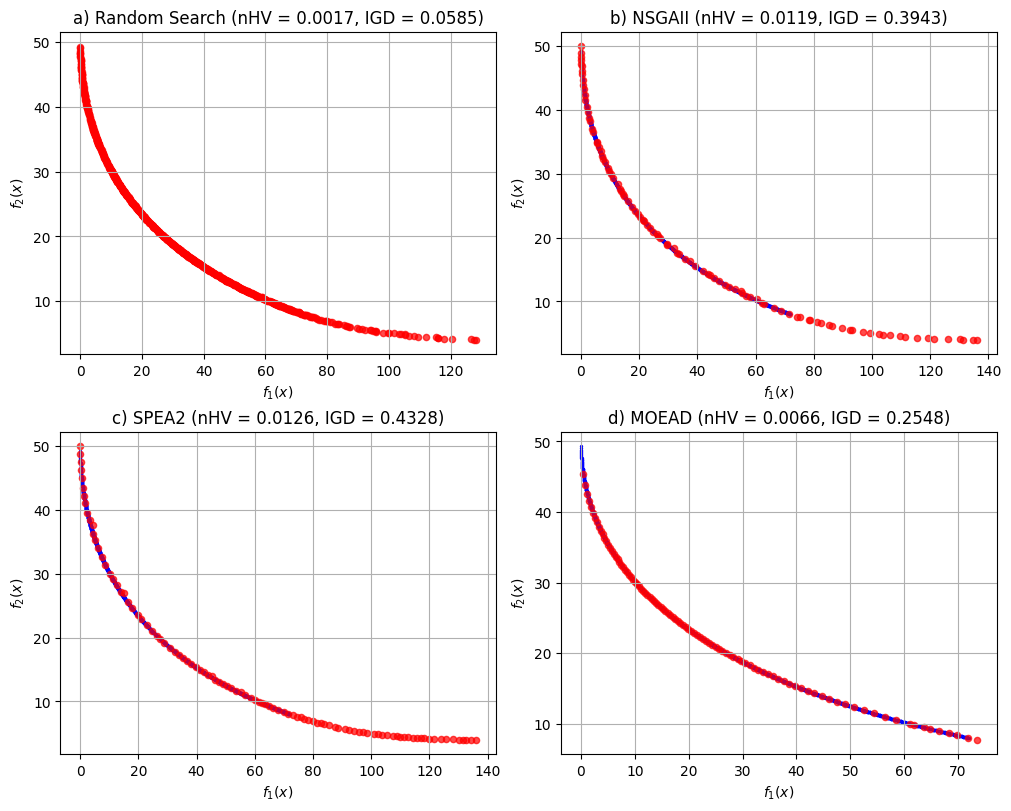

In [6]:
generate_plots(problem.name())